In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sklearn.tree
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
PRICE_XL_PATH       = "Indices.xlsx"
PRICE_XL_SHEET_NAME = "Index US"
MACRO_CSV_PATH      = "US_economic_data.csv"
index_to_predict = 'S&P500'
economic_csv = 'US_economic_data.csv'
economic_xlx = 'macro_data.xlsx'
stop_loss = -0.02
take_profit = 0.08
Initial_capital = 1000000

#change here(sheetnames): each sheet represents data from specific years. 
#
# 1977to2022
# 1977to1986
# 1986to1995
# 1995to2004
# 2004to2013
# 2013to2022
# marketregime

#marketregime is regime based which is 2000 to 2022, changed to validation_ratio to 0.55.
#which means your test set is 50% and your train set is 45%. You can adjust your validation. 
#Based on which year is testing and which year is training for your regime.
sheet = 'marketregime'
validation_ratio = 0.3

In [3]:
# VIF dataframe
def vifdata(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns

    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                              for i in range(len(X.columns))]

    return vif_data

In [4]:
def importance_random_forest(X_train,y_train):
    from sklearn.ensemble import RandomForestRegressor

    # Create and fit a Random Forest model
    model = RandomForestRegressor()
    model.fit(X_train, y_train)

    # Get feature importances
    importances = model.feature_importances_

    # Print feature importances
    for feature, importance in zip(X_train.columns, importances):
        print(f"{feature}: {importance}")

In [5]:
def correlation_matrix(df):   
    plt.figure(figsize = (6, 6))
    heatmap = sns.heatmap(df.corr(), vmin = -1, vmax = 1, annot = True)
    heatmap.set_title('Macro Correlation Heatmap', fontdict = {'fontsize' : 18}, pad = 12)
    return heatmap

In [6]:
def tsplot(y, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,1)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))

        plt.tight_layout()

            CONSUMERCONFIDENCEINDEX  2YEARYIELD  10YEARYIELD  \
date                                                           
2000-01-31                 102.8381        6.40         6.63   
2000-02-29                 102.8921        6.63         6.60   
2000-03-31                 102.8094        6.38         6.58   
2000-04-30                 102.7905        6.30         6.49   
2000-05-31                 102.7646        6.38         6.62   

            CONSUMERSENTIMENT    CORECPI  COREPCE       CPI       GDP  \
date                                                                    
2000-01-31              112.0  73.809116   5733.3  2.738892  4.225956   
2000-02-29              111.3  74.098078   5799.9  3.221884  4.225956   
2000-03-31              107.1  74.510880   5845.4  3.757576  4.225956   
2000-04-30              109.2  74.676002   5835.4  3.068592  5.244683   
2000-05-31              110.7  74.676002   5860.8  3.188929  5.244683   

            INTERESTRATE_MM  LABORFORCE

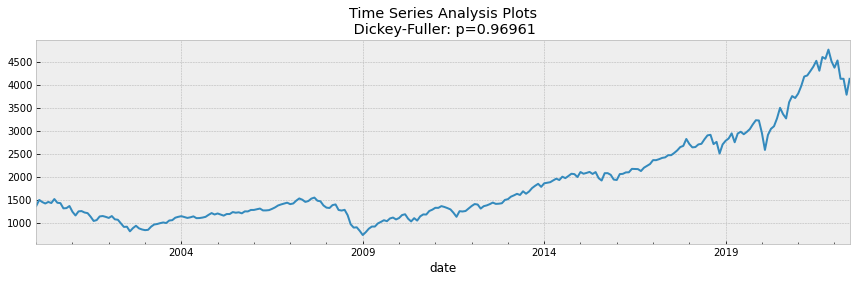

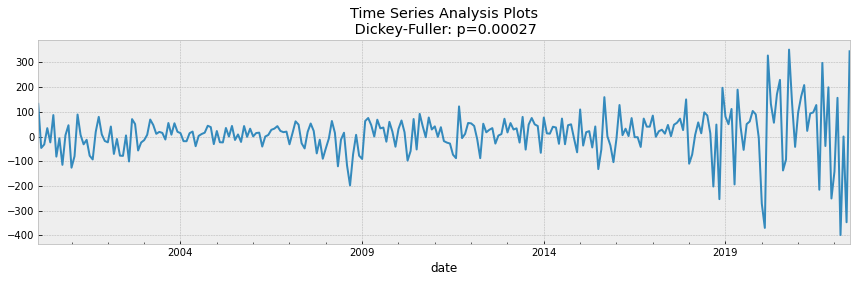

In [7]:
#load dataframe
#us_economic_data = pd.read_csv(economic_csv,index_col=None)
us_economic_data = pd.read_excel(economic_xlx, sheet_name=sheet, engine='openpyxl',index_col=None)
df = us_economic_data
#df = us_economic_data.iloc[:, :-2]

#Exploratory Data Analysis & Feature Selection
df.rename(columns = {'Unnamed: 0':'date'}, inplace = True)
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

print(df.head(5))

tsplot(df[index_to_predict])

data_diff = df[index_to_predict] - df[index_to_predict].shift(1)
#data_diff = ((df[index_to_predict] - df[index_to_predict].shift(1))/df[index_to_predict].shift(1))*100

tsplot(data_diff[1:])

In [8]:
df.columns

Index(['CONSUMERCONFIDENCEINDEX', '2YEARYIELD', '10YEARYIELD',
       'CONSUMERSENTIMENT', 'CORECPI', 'COREPCE', 'CPI', 'GDP',
       'INTERESTRATE_MM', 'LABORFORCE_FORECAST', 'MEDIANHOUSESALES',
       'MONTHLYHOUSESUPPLY', 'UNEMPLOYMENTFORECAST', 'NON_FARM',
       'REAL_GDP_FORECAST', 'SHORTINTERESTRATE_FORECAST', 'UNEMPLOYMENTRATE',
       'CPI_FORECAST', 'S&P500_price', 'S&P500'],
      dtype='object')

In [9]:
X = df.iloc[:, :-2]
Initial_X = X
vifdata(X)

,feature,VIF
0,CONSUMERCONFIDENCEINDEX,197121.367873
1,2YEARYIELD,65.751761
2,10YEARYIELD,130.280323
3,CONSUMERSENTIMENT,1493.948237
4,CORECPI,27780.326619
5,COREPCE,8527.636960
6,CPI,85.262433
7,GDP,7.108733
8,INTERESTRATE_MM,268.320667
9,LABORFORCE_FORECAST,38436.968662


In [10]:
# the independent variables set
X = df.iloc[:, :-2]
VIF = vifdata(X)
features_list_old = VIF['feature'].tolist()
features_list_old.append(index_to_predict)
while VIF['VIF'].max() >= 11:
    max_VIF = VIF['VIF'].idxmax()
    feature_row = VIF.loc[max_VIF,'feature']
    X = X.drop([feature_row],axis=1)
    VIF = vifdata(X)
features_list = VIF['feature'].tolist()
features_list.append(index_to_predict)
print(features_list)

['10YEARYIELD', 'CPI', 'GDP', 'INTERESTRATE_MM', 'MEDIANHOUSESALES', 'REAL_GDP_FORECAST', 'S&P500']


In [11]:
df_new = df[features_list]
df_old = df[features_list_old]
df_old.drop(columns = [index_to_predict], axis = 1)
print(df_old)

            CONSUMERCONFIDENCEINDEX  2YEARYIELD  10YEARYIELD  \
date                                                           
2000-01-31                102.83810        6.40         6.63   
2000-02-29                102.89210        6.63         6.60   
2000-03-31                102.80940        6.38         6.58   
2000-04-30                102.79050        6.30         6.49   
2000-05-31                102.76460        6.38         6.62   
...                             ...         ...          ...   
2022-02-28                 97.31078        1.16         1.78   
2022-03-31                 97.07170        0.78         1.63   
2022-04-30                 96.90445        0.77         1.66   
2022-05-31                 96.49539        0.83         1.71   
2022-06-30                 96.08616        0.88         1.73   

            CONSUMERSENTIMENT     CORECPI  COREPCE       CPI       GDP  \
date                                                                     
2000-01-31         

In [12]:
#df_z_scaled = df_new.copy()
df_z_scaled = df_old.copy()
print(df_z_scaled)
  
#apply normalization techniques
for column in df_z_scaled.columns:
    df_z_scaled[column] = (df_z_scaled[column] -
                           df_z_scaled[column].mean()) / df_z_scaled[column].std()    
    

            CONSUMERCONFIDENCEINDEX  2YEARYIELD  10YEARYIELD  \
date                                                           
2000-01-31                102.83810        6.40         6.63   
2000-02-29                102.89210        6.63         6.60   
2000-03-31                102.80940        6.38         6.58   
2000-04-30                102.79050        6.30         6.49   
2000-05-31                102.76460        6.38         6.62   
...                             ...         ...          ...   
2022-02-28                 97.31078        1.16         1.78   
2022-03-31                 97.07170        0.78         1.63   
2022-04-30                 96.90445        0.77         1.66   
2022-05-31                 96.49539        0.83         1.71   
2022-06-30                 96.08616        0.88         1.73   

            CONSUMERSENTIMENT     CORECPI  COREPCE       CPI       GDP  \
date                                                                     
2000-01-31         

CONSUMERCONFIDENCEINDEX: 0.0021761215265254964
2YEARYIELD: 0.0035749223068542303
10YEARYIELD: 0.005979872364942626
CONSUMERSENTIMENT: 0.0018658461250474156
CORECPI: 0.22359881169552656
COREPCE: 0.12405048994535597
CPI: 0.0021436692743937668
GDP: 0.004983925939290526
INTERESTRATE_MM: 0.0022638781356898465
LABORFORCE_FORECAST: 0.00303134015851203
MEDIANHOUSESALES: 0.3432955988342818
MONTHLYHOUSESUPPLY: 0.0027761653571117656
UNEMPLOYMENTFORECAST: 0.2667262400828789
NON_FARM: 0.0028792357596794564
REAL_GDP_FORECAST: 0.0012693660106575604
SHORTINTERESTRATE_FORECAST: 0.0023400625632540206
UNEMPLOYMENTRATE: 0.0017897795224524756
CPI_FORECAST: 0.005254674397545564
Shape of training data: (216, 18)
Shape of the training target data: (216, 1)
Shape of test data: (54, 18)
Shape of the test target data: (54, 1)
0.9830771840922684
0.9830771840922684
LR Intercept: 
 [0.00470121]
MSE:  0.016774367722939193
RMSE:  0.008387183861469596
r2 score for Linear Regression model is 0.9830771840922684
R-square

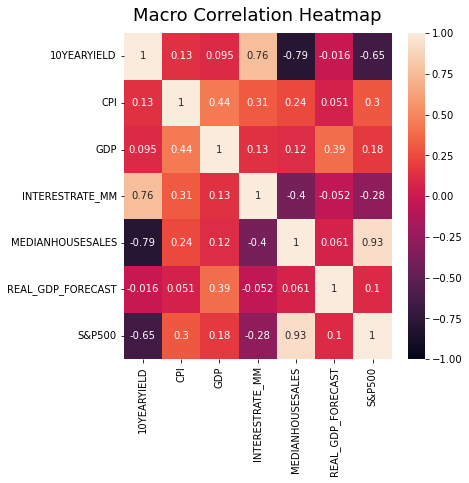

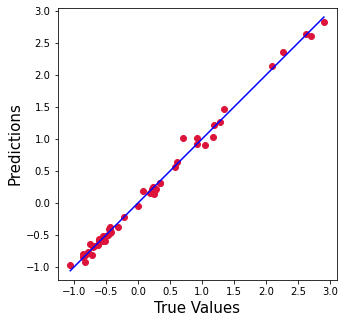

In [13]:
features = df_z_scaled.drop(columns = [index_to_predict], axis = 1)
labels = df_z_scaled[[index_to_predict]]
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 0)

correlation_matrix(df_new)
importance_random_forest(X_train,y_train)
print(f"Shape of training data: {X_train.shape}")
print(f"Shape of the training target data: {y_train.shape}")

print(f"Shape of test data: {X_test.shape}")
print(f"Shape of the test target data: {y_test.shape}")

regr = LinearRegression()
  
regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))

regr = LinearRegression()
  
regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))

coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(regr.coef_))], axis = 1)
coefficients

print('LR Intercept: \n', regr.intercept_)

y_pred = regr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 

r2 = r2_score(y_test, y_pred)
print('r2 score for Linear Regression model is', r2)


rfr = RandomForestRegressor()

rfr.fit(X_train, y_train)

score = rfr.score(X_train, y_train)
print("R-squared:", score)

ypred = rfr.predict(X_test)

mse = mean_squared_error(y_test, ypred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 

r2 = r2_score(y_test, ypred)
print('r2 score for Random Forest model is', r2)

plt.figure(figsize=(5,5))
plt.scatter(y_test[index_to_predict].values, ypred, c='crimson')


p1 = max(max(ypred), max(y_test[index_to_predict].values))
p2 = min(min(ypred), min(y_test[index_to_predict].values))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()



In [14]:
prices_df = pd.read_excel(PRICE_XL_PATH, sheet_name=PRICE_XL_SHEET_NAME)
prices_df = prices_df.set_index("Date_Work").sort_index()
prices_df = prices_df[[col for col in prices_df.columns if "Index" in col]].ffill()
prices_df.index = prices_df.index.to_period("M").to_timestamp("M")

In [15]:
df_z_scaled.to_csv('macro.csv')
#macro_df = pd.read_csv(MACRO_CSV_PATH, index_col=0)
macro_df = pd.read_csv('macro.csv', index_col=0)
macro_df.index = pd.to_datetime(macro_df.index)
macro_df.index = macro_df.index.to_period("M").to_timestamp("M")

In [16]:
# Exclude those too far back with NAs
#prices_df = prices_df.loc[:, (prices_df.isna().sum() < 30)].dropna(axis=0)
prices_df = prices_df.loc[:, (prices_df.isna().sum() < 30)].fillna(method='ffill')
macro_df  = macro_df.loc[prices_df.index[0] : prices_df.index[-1]]
prices_df = prices_df.loc[macro_df.index[0] : macro_df.index[-1]]

#df_old = df_old.loc[prices_df.index[0] : prices_df.index[-1]]
#prices_df = prices_df.loc[df_old.index[0] : df_old.index[-1]]

In [17]:
# Sanity check
set(prices_df.index) - set(macro_df.index), set(macro_df.index) - set(prices_df.index)

(set(), set())

In [18]:
macro_df

,CONSUMERCONFIDENCEINDEX,2YEARYIELD,10YEARYIELD,CONSUMERSENTIMENT,CORECPI,COREPCE,CPI,GDP,INTERESTRATE_MM,LABORFORCE_FORECAST,MEDIANHOUSESALES,MONTHLYHOUSESUPPLY,UNEMPLOYMENTFORECAST,NON_FARM,REAL_GDP_FORECAST,SHORTINTERESTRATE_FORECAST,UNEMPLOYMENTRATE,CPI_FORECAST,S&P500
date,,,,,,,,,,,,,,,,,,,
2000-01-31,2.046929,2.505169,2.431852,2.180241,-1.657493,-1.585509,0.220091,0.943047,2.191634,-1.910845,-1.488111,-0.791808,1.826425,-1.003428,-0.115980,2.245813,1.885326,0.553687,-0.505204
2000-02-29,2.083539,2.637540,2.409904,2.124401,-1.633270,-1.557826,0.515687,0.943047,2.223427,-1.910845,-1.488111,-0.791808,1.826425,-0.987201,-0.115980,2.245813,1.893769,0.553687,-0.364275
2000-03-31,2.027471,2.493659,2.395272,1.789361,-1.598666,-1.538913,0.843535,0.943047,2.292311,-1.910845,-1.488111,-0.791808,1.826425,-0.916297,-0.115980,2.245813,1.876175,0.553687,-0.413487
2000-04-30,2.014657,2.447617,2.329427,1.956881,-1.584825,-1.543069,0.421870,1.387431,2.366495,-1.879715,-1.520758,-0.738903,1.780219,-0.875509,0.986269,2.533205,1.991384,0.576374,-0.447429
2000-05-31,1.997098,2.493659,2.424536,2.076538,-1.584825,-1.532511,0.495518,1.387431,2.594344,-1.879715,-1.520758,-0.738903,1.780219,-0.843054,0.986269,2.533205,1.804362,0.576374,-0.411173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-28,-1.700404,-0.510575,-1.116428,-1.744512,2.123293,2.208916,3.361030,0.706498,-0.759812,1.616631,2.675193,0.107573,-1.663053,1.920576,-0.683247,-0.729223,0.414697,3.538835,2.868732
2022-03-31,-1.862493,-0.729274,-1.226168,-2.015734,2.166409,2.256427,3.771929,0.706498,-0.574353,1.616631,2.675193,0.636621,-1.663053,1.981100,-0.683247,-0.729223,0.597459,3.538835,2.443811
2022-04-30,-1.975882,-0.735029,-1.204220,-1.553060,2.219734,2.290928,3.598224,-0.116918,-0.478975,1.636080,2.927044,1.377287,-1.685082,2.018233,-0.490193,-0.236045,0.575501,3.904059,2.444045


In [19]:
macro_df.head()

,CONSUMERCONFIDENCEINDEX,2YEARYIELD,10YEARYIELD,CONSUMERSENTIMENT,CORECPI,COREPCE,CPI,GDP,INTERESTRATE_MM,LABORFORCE_FORECAST,MEDIANHOUSESALES,MONTHLYHOUSESUPPLY,UNEMPLOYMENTFORECAST,NON_FARM,REAL_GDP_FORECAST,SHORTINTERESTRATE_FORECAST,UNEMPLOYMENTRATE,CPI_FORECAST,S&P500
date,,,,,,,,,,,,,,,,,,,
2000-01-31,2.046929,2.505169,2.431852,2.180241,-1.657493,-1.585509,0.220091,0.943047,2.191634,-1.910845,-1.488111,-0.791808,1.826425,-1.003428,-0.115980,2.245813,1.885326,0.553687,-0.505204
2000-02-29,2.083539,2.637540,2.409904,2.124401,-1.633270,-1.557826,0.515687,0.943047,2.223427,-1.910845,-1.488111,-0.791808,1.826425,-0.987201,-0.115980,2.245813,1.893769,0.553687,-0.364275
2000-03-31,2.027471,2.493659,2.395272,1.789361,-1.598666,-1.538913,0.843535,0.943047,2.292311,-1.910845,-1.488111,-0.791808,1.826425,-0.916297,-0.115980,2.245813,1.876175,0.553687,-0.413487
2000-04-30,2.014657,2.447617,2.329427,1.956881,-1.584825,-1.543069,0.421870,1.387431,2.366495,-1.879715,-1.520758,-0.738903,1.780219,-0.875509,0.986269,2.533205,1.991384,0.576374,-0.447429
2000-05-31,1.997098,2.493659,2.424536,2.076538,-1.584825,-1.532511,0.495518,1.387431,2.594344,-1.879715,-1.520758,-0.738903,1.780219,-0.843054,0.986269,2.533205,1.804362,0.576374,-0.411173


In [20]:
prices_df.head()

,CTRN Index,RTY Index,INDU Index,CBNK Index,NYA Index,CFIN Index,CINS Index,TRAN Index,CUTL Index,SPX Index,CCMP Index,UTIL Index,RIY Index,RAY Index,CIND Index
Date_Work,,,,,,,,,,,,,,,
2000-01-31,943.11,496.954,10940.54,1587.14,6574.01,3140.33,1769.67,2571.65,987.44,1394.46,3940.35,315.14,736.109,761.851,2199.76
2000-02-29,961.24,578.471,10128.31,1449.11,6266.42,3201.81,1725.53,2388.86,1141.10,1366.42,4696.69,288.48,733.239,767.986,2623.64
2000-03-31,1012.73,539.733,10921.93,1530.54,6848.61,3282.30,1928.43,2763.24,1102.01,1498.58,4572.83,291.77,799.208,827.275,2420.17
2000-04-30,1044.38,506.902,10733.92,1493.63,6811.17,2657.83,1841.37,2850.01,890.49,1452.43,3860.66,317.75,771.963,797.504,2120.92
2000-05-31,995.44,476.832,10522.34,1557.02,6805.25,2373.66,1844.90,2709.99,754.78,1420.6,3400.91,328.53,751.027,774.115,1849.51


In [21]:
# <span style="font-size:larger;">Features Importance</span>

In [22]:
# Clean strings in numeric columns
for col in prices_df.columns:
    if prices_df[col].dtype != np.float64:
        # Convert the column values to numeric type
        prices_df[col] = pd.to_numeric(prices_df[col], errors='coerce')

        # Replace values containing '#' with NaN
        prices_df.loc[prices_df[col].isna(), col] = np.nan

        # Forward fill the NaN values in the column
        prices_df[col].ffill(inplace=True)

In [23]:
df_old

,CONSUMERCONFIDENCEINDEX,2YEARYIELD,10YEARYIELD,CONSUMERSENTIMENT,CORECPI,COREPCE,CPI,GDP,INTERESTRATE_MM,LABORFORCE_FORECAST,MEDIANHOUSESALES,MONTHLYHOUSESUPPLY,UNEMPLOYMENTFORECAST,NON_FARM,REAL_GDP_FORECAST,SHORTINTERESTRATE_FORECAST,UNEMPLOYMENTRATE,CPI_FORECAST,S&P500
date,,,,,,,,,,,,,,,,,,,
2000-01-31,102.83810,6.40,6.63,112.0,73.809116,5733.3,2.738892,4.225956,5.95,142385666.7,165300,4.3,5.224948,131009,1.465778,6.033333,74.26526,3.257790,1366.42
2000-02-29,102.89210,6.63,6.60,111.3,74.098078,5799.9,3.221884,4.225956,6.01,142385666.7,165300,4.3,5.224948,131120,1.465778,6.033333,74.28468,3.257790,1498.58
2000-03-31,102.80940,6.38,6.58,107.1,74.510880,5845.4,3.757576,4.225956,6.14,142385666.7,165300,4.3,5.224948,131605,1.465778,6.033333,74.24421,3.257790,1452.43
2000-04-30,102.79050,6.30,6.49,109.2,74.676002,5835.4,3.068592,5.244683,6.28,142576666.7,163200,4.4,5.214622,131884,7.483628,6.573333,74.50922,3.293834,1420.60
2000-05-31,102.76460,6.38,6.62,110.7,74.676002,5860.8,3.188929,5.244683,6.71,142576666.7,163200,4.4,5.214622,132106,7.483628,6.573333,74.07902,3.293834,1454.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-28,97.31078,1.16,1.78,62.8,118.911522,14861.7,7.871064,3.683679,0.38,164029000.0,433100,6.0,4.445137,151010,-1.631278,0.443333,70.88243,8.000390,4530.41
2022-03-31,97.07170,0.78,1.63,59.4,119.425874,14976.0,8.542456,3.683679,0.73,164029000.0,433100,7.0,4.445137,151424,-1.631278,0.443333,71.30283,8.000390,4131.93
2022-04-30,96.90445,0.77,1.66,65.2,120.062003,15059.0,8.258630,1.796042,0.91,164148333.3,449300,8.4,4.440214,151678,-0.577282,1.370000,71.25232,8.580631,4132.15


In [24]:
# features_importance_df = pd.concat([df_old,prices_df],axis=1)

# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler

# # Standardize the features by scaling them to have zero mean and unit variance
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(df_old)

# # Create a PCA instance and specify the desired number of components
# n_components = min(X_scaled.shape[1], X_scaled.shape[0])  # Adjust this value based on your requirements
# pca = PCA(n_components=n_components)

# # Fit the PCA model to the scaled data
# pca.fit(X_scaled)

# # Transform the data to the lower-dimensional space
# X_pca = pca.transform(X_scaled)

# # Create a DataFrame to store the transformed features
# transformed_df = pd.DataFrame(X_pca, columns=[f'Component {i+1}' for i in range(n_components)])

# print(transformed_df)
# print(prices_df)
# print(macro_df)

In [25]:
def shift(df, n):
    df = df.shift(n)
    df.columns = [col + str(n) for col in df.columns]
    return df

In [26]:
#x = macro_df.pct_change().dropna()
x = macro_df
#x = transformed_df
#x = x[["COREPCE", "CPI", "GDP", "INTERESTRATE_MM", "REAL_GDP_FORECAST"]]
#x = pd.concat([x, shift(x, 1), shift(x, 2), shift(x, 3)], axis=1).dropna().iloc[:-1]
x = pd.concat([x, x.fillna(method='ffill').shift(1), x.fillna(method='ffill').shift(2), x.fillna(method='ffill').shift(3)], axis=1).dropna().iloc[:-1]
print(x)

            CONSUMERCONFIDENCEINDEX  2YEARYIELD  10YEARYIELD  \
date                                                           
2000-04-30                 2.014657    2.447617     2.329427   
2000-05-31                 1.997098    2.493659     2.424536   
2000-06-30                 1.928691    2.476393     2.387956   
2000-07-31                 1.905505    2.453372     2.351375   
2000-08-31                 1.881369    2.672071     2.402588   
...                             ...         ...          ...   
2022-01-31                -1.490561   -0.654456    -1.174956   
2022-02-28                -1.700404   -0.510575    -1.116428   
2022-03-31                -1.862493   -0.729274    -1.226168   
2022-04-30                -1.975882   -0.735029    -1.204220   
2022-05-31                -2.253211   -0.700498    -1.167640   

            CONSUMERSENTIMENT   CORECPI   COREPCE       CPI       GDP  \
date                                                                    
2000-04-30           

macro df: 
             CONSUMERCONFIDENCEINDEX  2YEARYIELD  10YEARYIELD  \
date                                                           
2000-01-31                 2.046929    2.505169     2.431852   
2000-02-29                 2.083539    2.637540     2.409904   

            CONSUMERSENTIMENT   CORECPI   COREPCE       CPI       GDP  \
date                                                                    
2000-01-31           2.180241 -1.657493 -1.585509  0.220091  0.943047   
2000-02-29           2.124401 -1.633270 -1.557826  0.515687  0.943047   

            INTERESTRATE_MM  LABORFORCE_FORECAST  MEDIANHOUSESALES  \
date                                                                 
2000-01-31         2.191634            -1.910845         -1.488111   
2000-02-29         2.223427            -1.910845         -1.488111   

            MONTHLYHOUSESUPPLY  UNEMPLOYMENTFORECAST  NON_FARM  \
date                                                             
2000-01-31           -0.7

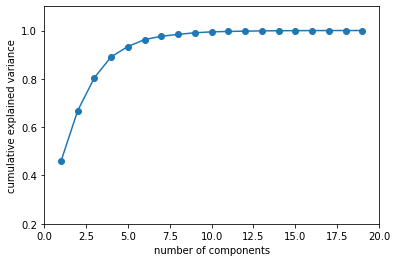

In [27]:
#features_importance_df = pd.concat([df_old,prices_df],axis=1)
#features_importance_df = df_old
features_importance_df = macro_df
print("macro df: \n", macro_df.head(2))
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the features by scaling them to have zero mean and unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_importance_df)

# Create a PCA instance and specify the desired number of components
n_components = min(X_scaled.shape[1], X_scaled.shape[0])  # Adjust this value based on your requirements
#n_components = 6
pca = PCA(n_components=n_components)
# Fit the PCA model to the scaled data
pca.fit(X_scaled)

# Transform the data to the lower-dimensional space
X_pca = pca.transform(X_scaled)

# Create a DataFrame to store the transformed features
transformed_df = pd.DataFrame(X_pca, columns=[f'Component {i+1}' for i in range(n_components)])

plt.plot(range(1,n_components+1),np.cumsum(pca.explained_variance_ratio_))
plt.scatter(range(1,n_components+1),np.cumsum(pca.explained_variance_ratio_))

plt.xlim(0,n_components+1)
plt.ylim(0.2,1.1)
plt.xlabel("number of components")
plt.ylabel("cumulative explained variance")
plt.show()

In [28]:
comp_idx = np.argmax((pca.explained_variance_ / pca.explained_variance_.sum()).cumsum() > 0.99) + 1
eigen_vectors = pca.components_[:, :comp_idx]

In [29]:
eigen_vectors.shape,features_importance_df.shape

((19, 9), (270, 19))

In [30]:
X_scaled.shape

(270, 19)

In [31]:
x_final = X_scaled @ eigen_vectors

In [32]:
# x = macro_df.pct_change().dropna().iloc[:-1]
#y = prices_df.pct_change().dropna().shift(-1).loc[x.index]
y = prices_df.pct_change().shift(-1).loc[features_importance_df.index].ffill()

In [33]:
split_index      = int(macro_df.shape[0] * validation_ratio)

<br>

In [34]:
x.shape

(266, 76)

In [35]:
x_train = x_final[:-split_index]
y_train = y.iloc[:-split_index]
x_val   = x_final[-split_index:]
y_val   = y.iloc[-split_index:]

print(x_train)

[[-2.26777554  1.04322575 -0.94557383 ... -2.10750654 -0.10642137
   2.09178898]
 [-2.27692711  1.06033352 -0.96778946 ... -2.14666691 -0.05169327
   2.13915609]
 [-2.23086104  1.04470383 -1.03737954 ... -2.03995152  0.2319594
   2.1971945 ]
 ...
 [ 1.28908209  0.37923541  0.71155855 ... -0.21054909 -0.90676916
  -0.63810921]
 [ 1.23328308  0.34915666  0.62657229 ... -0.23407427 -0.8678675
  -0.70791231]
 [ 1.30129374  0.12125409  0.65349315 ...  0.1506171  -0.72640156
  -0.79719496]]


In [36]:
#model = LR()
# model = ElasticNet(alpha=0.0)
#model = DecisionTreeRegressor(max_depth=5)
#model = LinearRegression()
# Random Forest of Regression Stumps
model = RandomForestRegressor(n_estimators=40, max_depth=1, max_features=1, random_state=0)

In [37]:
model.fit(x_train, y_train)

RandomForestRegressor(max_depth=1, max_features=1, n_estimators=40,
                      random_state=0)

In [38]:
model.score(x_train, y_train), model.score(x_val, y_val)

(0.037832097671002526, 0.015075238881641306)

In [39]:
x.columns

Index(['CONSUMERCONFIDENCEINDEX', '2YEARYIELD', '10YEARYIELD',
       'CONSUMERSENTIMENT', 'CORECPI', 'COREPCE', 'CPI', 'GDP',
       'INTERESTRATE_MM', 'LABORFORCE_FORECAST', 'MEDIANHOUSESALES',
       'MONTHLYHOUSESUPPLY', 'UNEMPLOYMENTFORECAST', 'NON_FARM',
       'REAL_GDP_FORECAST', 'SHORTINTERESTRATE_FORECAST', 'UNEMPLOYMENTRATE',
       'CPI_FORECAST', 'S&P500', 'CONSUMERCONFIDENCEINDEX', '2YEARYIELD',
       '10YEARYIELD', 'CONSUMERSENTIMENT', 'CORECPI', 'COREPCE', 'CPI', 'GDP',
       'INTERESTRATE_MM', 'LABORFORCE_FORECAST', 'MEDIANHOUSESALES',
       'MONTHLYHOUSESUPPLY', 'UNEMPLOYMENTFORECAST', 'NON_FARM',
       'REAL_GDP_FORECAST', 'SHORTINTERESTRATE_FORECAST', 'UNEMPLOYMENTRATE',
       'CPI_FORECAST', 'S&P500', 'CONSUMERCONFIDENCEINDEX', '2YEARYIELD',
       '10YEARYIELD', 'CONSUMERSENTIMENT', 'CORECPI', 'COREPCE', 'CPI', 'GDP',
       'INTERESTRATE_MM', 'LABORFORCE_FORECAST', 'MEDIANHOUSESALES',
       'MONTHLYHOUSESUPPLY', 'UNEMPLOYMENTFORECAST', 'NON_FARM',
       'R

In [40]:
pca.components_[:,2]

array([ 0.3224135 , -0.05606953,  0.06631527,  0.0324061 , -0.03611457,
        0.02852041, -0.01271139,  0.2380384 , -0.53235699,  0.44515255,
       -0.48972274,  0.16955592, -0.25264729, -0.10102261,  0.00968184,
       -0.02786935, -0.05322048,  0.0250084 , -0.00308335])

In [41]:
N = 6
def get_weights(row):
    sorted_row = row.sort_values()
    long_weights = sorted_row.iloc[-N:]
    long_weights = long_weights / long_weights.abs().sum()
    weights_dict = long_weights.to_dict()
    for name_to_short, long_weight in zip(sorted_row.iloc[:N][::-1].index, long_weights):
        weights_dict[name_to_short] = -long_weight

    return pd.Series(weights_dict)

<br>

In [42]:
y_train_pred = model.predict(x_train)
y_train_pred = pd.DataFrame(y_train_pred, index=y_train.index, columns=y_train.columns)

In [43]:
model.score(x_train, y_train)

0.037832097671002526

In [44]:
weights_df = y_train_pred.apply(get_weights, axis=1).fillna(0.0)

pnls = (weights_df * y_train.shift(-1)).fillna(0.0)

pnl_series = pnls.sum(axis=1)

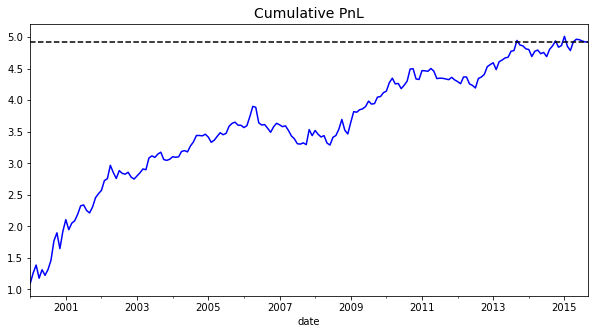

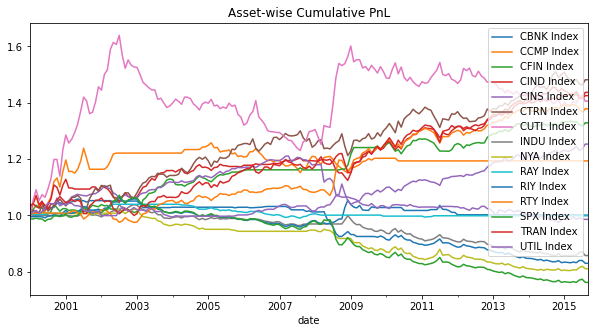

In [45]:
value_series = (1 + pnl_series).cumprod()
value_series.plot(figsize=(10, 5), c="b")
plt.title("Cumulative PnL", fontsize=14)
plt.axhline(value_series[-1], c="k", linestyle="--")

asset_pnl_serieses = (1 + pnls).cumprod()
asset_pnl_serieses.plot(figsize=(10, 5))
plt.title("Asset-wise Cumulative PnL")
plt.show()

#### Sharpe

In [46]:
train_pnl_mean = pnl_series.mean() * 12
train_pnl_std  = pnl_series.std() * np.sqrt(12)
train_sharpe   = train_pnl_mean / train_pnl_std
train_pnl_mean, train_pnl_std, train_sharpe

(0.1107196225066444, 0.13698112949183838, 0.8082837608171518)

#### Max Drawdown

In [47]:
max_drawdown = 1 - (value_series / value_series.cummax()).min()
max_drawdown

0.15705227295593882

#### Beta

In [48]:
spx    = y_train["SPX Index"].values.reshape(-1, 1)
beta_x = np.hstack([np.ones_like(spx), spx])[:-1]
beta_y = pnl_series.values.reshape(-1, 1)[:-1]

In [49]:
alpha, beta = np.linalg.inv(beta_x.T @ beta_x) @ (beta_x.T @ beta_y).reshape(-1)
alpha, beta

(0.009076134263389168, 0.07499393292560182)

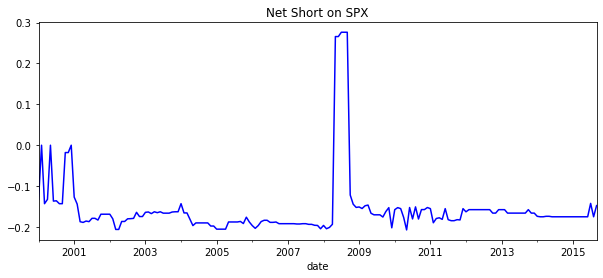

In [50]:
# SPX tends to fall into bottom category since it is supposedly the more diversified index
plt.title("Net Short on SPX")
weights_df["SPX Index"].plot(c="b", figsize=(10, 4))
plt.show()

<br><br><br>

## Validation

In [51]:
y_val_pred = model.predict(x_val)
y_val_pred = pd.DataFrame(y_val_pred, index=y_val.index, columns=y_val.columns)

In [52]:
model.score(x_val, y_val)

0.015075238881641306

In [53]:
weights_df = y_val_pred.apply(get_weights, axis=1).fillna(0.0)

pnls = (weights_df * y_val.shift(-1)).fillna(0.0)
#pnls = (weights_df * y_val.shift).fillna(0.0)

#implement stoploss
pnls[pnls < stop_loss] = stop_loss
#implement takeprofit
pnls[pnls > take_profit] = take_profit
pnl_series = pnls.sum(axis=1)

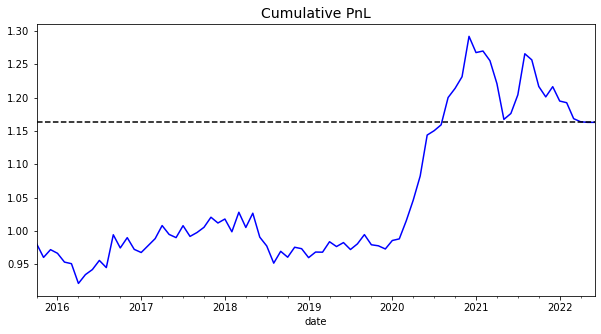

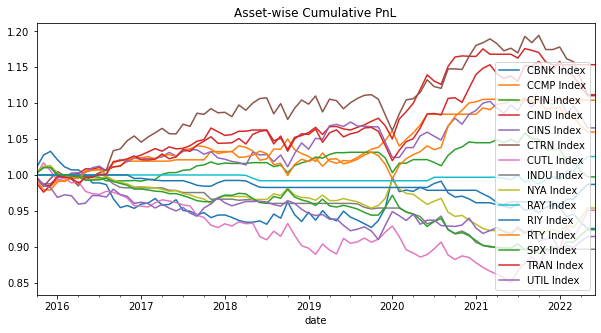

In [54]:
value_series = (1 + pnl_series).cumprod()
value_series.plot(figsize=(10, 5), c="b")
plt.title("Cumulative PnL", fontsize=14)
plt.axhline(value_series[-1], c="k", linestyle="--")

asset_pnl_serieses = (1 + pnls).cumprod()
asset_pnl_serieses.plot(figsize=(10, 5))
plt.title("Asset-wise Cumulative PnL")
plt.show()

#### Sharpe

In [55]:
val_pnl_mean = pnl_series.mean() * 12
val_pnl_std  = pnl_series.std() * np.sqrt(12)
val_sharpe   = val_pnl_mean / train_pnl_std

val_pnl_mean, val_pnl_std, val_sharpe

(0.02479522849576877, 0.07042879090905771, 0.1810120020746808)

#### Average Portfolio Return per year

In [56]:
Investment_Value = Initial_capital*(1+val_pnl_mean)
Investment_Value

1024795.2284957689

#### Porfolio Value After n years based on data

In [57]:
Investment_Value_n_years = Initial_capital*(1+pnl_series.sum())
Investment_Value_n_years

1167367.792346439

#### CAGR

In [58]:
val_cagr = (value_series[-1]**(12/len(value_series)))-1
val_cagr

0.022594503238923647

#### Max Drawdown

In [59]:
max_drawdown = 1 - (value_series / value_series.cummax()).min()
max_drawdown

0.09987030833407684

#### Beta

In [60]:
spx    = y_val["SPX Index"].values.reshape(-1, 1)
beta_x = np.hstack([np.ones_like(spx), spx])[:-1]
beta_y = pnl_series.values.reshape(-1, 1)[:-1]

In [61]:
alpha, beta = np.linalg.inv(beta_x.T @ beta_x) @ (beta_x.T @ beta_y).reshape(-1)
alpha, beta

(0.002459068108836389, -0.043288000517957864)

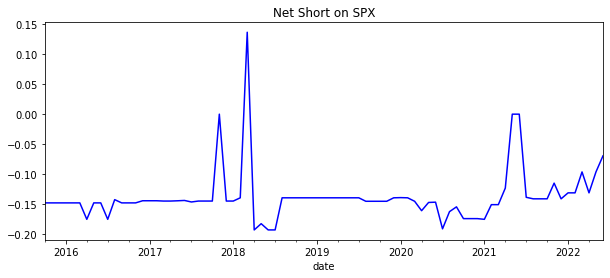

In [62]:
# SPX tends to fall into bottom category since it is supposedly the more diversified index
plt.title("Net Short on SPX")
weights_df["SPX Index"].plot(c="b", figsize=(10, 4))
plt.show()

## BACKTESTING

In [63]:
start_date = pnls.index.min()
end_date = pnls.index.max()
print("Start Date:", start_date)
print("End Date:", end_date)

Start Date: 2015-10-31 00:00:00
End Date: 2022-06-30 00:00:00


In [64]:
# fama french data factors
fafr5 = pd.read_csv('F-F_Research_Data_5_Factors_2x3.csv', skiprows=3, nrows=718, parse_dates=True, index_col=0, date_parser=lambda x:pd.to_datetime(x, format='%Y%m'))
fafr5

,Mkt-RF,SMB,HML,RMW,CMA,RF
1963-07-01,-0.39,-0.41,-0.97,0.68,-1.18,0.27
1963-08-01,5.07,-0.80,1.80,0.36,-0.35,0.25
1963-09-01,-1.57,-0.52,0.13,-0.71,0.29,0.27
1963-10-01,2.53,-1.39,-0.10,2.80,-2.01,0.29
1963-11-01,-0.85,-0.88,1.75,-0.51,2.24,0.27
...,...,...,...,...,...,...
2022-12-01,-6.41,-0.16,1.32,0.09,4.19,0.33
2023-01-01,6.65,4.43,-4.05,-2.62,-4.53,0.35
2023-02-01,-2.58,0.69,-0.78,0.90,-1.41,0.34
2023-03-01,2.51,-7.01,-9.01,1.92,-2.29,0.36


In [65]:
rfr = fafr5["RF"]/100
rfr = rfr.loc[(rfr.index >= start_date) & (rfr.index <= end_date + pd.offsets.DateOffset(months=1))]
rfr

2015-11-01    0.0000
2015-12-01    0.0001
2016-01-01    0.0001
2016-02-01    0.0002
2016-03-01    0.0002
               ...  
2022-03-01    0.0001
2022-04-01    0.0001
2022-05-01    0.0003
2022-06-01    0.0006
2022-07-01    0.0008
Name: RF, Length: 81, dtype: float64

In [66]:
def get_buynhold(df,start,end,rf_rate):
    df1 = df.copy()
    df1 = df1.loc[start:end]
    df2 = rf_rate.copy()
    df2 = df2.loc[start:end]
    combined = []
    for count, i in enumerate(df1.columns):
        cum_ret = (1+ df1.iloc[:,count]).cumprod()
        sharpe = ((df1.iloc[:,count]-df2).mean()/((df1.iloc[:,count]-df2).std()))*np.sqrt(12)
        cagr = (cum_ret[-1]**(12/len(df1.iloc[:,count])))-1
        maxd = 1 - (cum_ret / cum_ret.cummax()).min()
        vol =  (df1.iloc[:,count].std())*np.sqrt(12)
        key = [sharpe,cagr,maxd,vol]
        stats = pd.DataFrame(key, index = ["BnH Sharpe","BnH CAGR","BnH Max Drawdown", "BnH Volatility"], columns = [df1.iloc[:,count].name])
        combined.append(stats)
        combined_df = pd.concat(combined, axis = 1).T
        
        
    return combined_df

In [67]:
rfr.index = y_val.index

In [68]:
y_val.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 81 entries, 2015-10-31 to 2022-06-30
Freq: M
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CTRN Index  81 non-null     float64
 1   RTY Index   81 non-null     float64
 2   INDU Index  81 non-null     float64
 3   CBNK Index  81 non-null     float64
 4   NYA Index   81 non-null     float64
 5   CFIN Index  81 non-null     float64
 6   CINS Index  81 non-null     float64
 7   TRAN Index  81 non-null     float64
 8   CUTL Index  81 non-null     float64
 9   SPX Index   81 non-null     float64
 10  CCMP Index  81 non-null     float64
 11  UTIL Index  81 non-null     float64
 12  RIY Index   81 non-null     float64
 13  RAY Index   81 non-null     float64
 14  CIND Index  81 non-null     float64
dtypes: float64(15)
memory usage: 10.1 KB


In [69]:
rfr.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 81 entries, 2015-10-31 to 2022-06-30
Freq: M
Series name: RF
Non-Null Count  Dtype  
--------------  -----  
81 non-null     float64
dtypes: float64(1)
memory usage: 1.3 KB


In [70]:
get_buynhold(y_val, start_date, end_date, rfr)

,BnH Sharpe,BnH CAGR,BnH Max Drawdown,BnH Volatility
CTRN Index,0.224962,0.034057,0.332755,0.213870
RTY Index,0.277752,0.045116,0.337584,0.206420
INDU Index,0.493766,0.074611,0.232013,0.152457
CBNK Index,0.234190,0.035917,0.425750,0.246150
NYA Index,0.251741,0.035769,0.259552,0.153884
CFIN Index,0.310646,0.047202,0.376483,0.167730
CINS Index,0.287126,0.041961,0.273957,0.157592
TRAN Index,0.342971,0.060768,0.320496,0.215811
CUTL Index,0.308050,0.049016,0.348870,0.180849
SPX Index,0.512414,0.078712,0.272434,0.155282


In [71]:
# pnl_series_pd = pd.DataFrame(pnl_series)
# pnl_series_pd

In [72]:
# get_buynhold(pnl_series_pd, start_date, end_date, rfr)